In [1]:
# !pip install pgvector psycopg2-binary gitpython -q

In [3]:

from pathlib import Path
from git import Repo

REPO_URL  = "https://github.com/langchain-ai/langgraph.git"
LOCAL_DIR = Path("LG-python")

if LOCAL_DIR.exists():
    repo = Repo(str(LOCAL_DIR))
    repo.remote().pull()          # fast refresh
else:
    Repo.clone_from(REPO_URL, LOCAL_DIR, depth=1)



In [4]:
# Cell 2 (replace)
import ast, textwrap, hashlib, inspect

def iter_code_chunks(py_path: Path):
    src = py_path.read_text(encoding="utf-8")
    try:
        tree = ast.parse(src)
    except SyntaxError:
        return

    # 1️⃣  top-level import block (file header)
    import_lines = [n for n in tree.body if isinstance(n, (ast.Import, ast.ImportFrom))]
    if import_lines:
        start = import_lines[0].lineno - 1
        end   = import_lines[-1].end_lineno
        block = "\n".join(src.splitlines()[start:end])
        uid   = hashlib.sha256(f"{py_path}:imports".encode()).hexdigest()
        yield {
            "id": uid,
            "content": block,
            "metadata": {"path": str(py_path.relative_to(LOCAL_DIR)),
                         "chunk_id": -1,
                         "source": "import_block"}
        }

    # 2️⃣  functions / classes with docstring merged
    for idx, node in enumerate(tree.body):
        if isinstance(node, (ast.FunctionDef, ast.ClassDef)):
            start = node.lineno - 1
            end   = getattr(node, "end_lineno", start + 1)
            lines = src.splitlines()
            body  = "\n".join(lines[start:end])

            # pull the docstring (if any) and prepend
            doc  = ast.get_docstring(node)
            if doc:
                body = f'"""{doc}"""\n' + body.replace(f'"""{doc}"""', "", 1)

            uid  = hashlib.sha256(f"{py_path}:{idx}".encode()).hexdigest()
            yield {
                "id": uid,
                "content": textwrap.dedent(body),
                "metadata": {"path": str(py_path.relative_to(LOCAL_DIR)),
                             "chunk_id": idx,
                             "source": "func" if isinstance(node, ast.FunctionDef) else "class"}
            }


In [21]:
RAW_DIR = Path("contextual_chunked_LG_docs/raw_chunks")
RAW_DIR.mkdir(parents=True, exist_ok=True)

from langchain_core.documents import Document                 # LangChain doc
contextual_chunks = []

for py in LOCAL_DIR.rglob("*.py"):
    for c in iter_code_chunks(py):
        # 3a. write each chunk as a .txt file for transparency
        safe_path = c["metadata"]["path"].replace("/", "__")
        fname = RAW_DIR / f"{safe_path}__{c['metadata']['chunk_id']}.txt"
        fname.write_text(c["content"], encoding="utf-8")
        # 3b. build Document
        contextual_chunks.append(Document(page_content=c["content"],
                                          metadata=c["metadata"]))


In [6]:
from langchain_community.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name = '/mnt/c/Users/Nikhil/Desktop/chai_code_genai/RAG_on_chaicode_docs_website/models/all-mpnet-base-v2',
                                        model_kwargs={'device': 'cuda'}) 

/tmp/ipykernel_761477/3190965533.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name = '/mnt/c/Users/Nikhil/Desktop/chai_code_genai/RAG_on_chaicode_docs_website/models/all-mpnet-base-v2',


In [23]:
                                                               # 384-d embs

vectorstore = Chroma.from_documents(
    documents=contextual_chunks,
    embedding=embedding_model,                                     # Embeddings obj
    collection_name="lg_code",
    persist_directory="contextual_chunked_LG_docs/github_lg"
)
vectorstore.persist()
print("✓ Chroma collection adk_code persisted in contextual_chunked_LG_docs")


✓ Chroma collection adk_code persisted in contextual_chunked_LG_docs


In [24]:
docs = vectorstore.similarity_search(
    "How to strore interactions in Database ?", k=5)
for d in docs:
    print(d.metadata["path"], "→", d.page_content.splitlines()[0][:80], "…")
    # print(d.metadata["path"], "→", d.page_content, "\n\n\n")


libs/sdk-py/langgraph_sdk/schema.py → """Base model for an assistant.""" …
libs/langgraph/bench/wide_dict.py → def wide_dict(n: int) -> StateGraph: …
libs/langgraph/bench/wide_state.py → def wide_state(n: int) -> StateGraph: …
libs/sdk-py/langgraph_sdk/schema.py → """Represents a conversation thread.""" …
libs/sdk-py/langgraph_sdk/schema.py → """Defines the structure and properties of a graph.""" …


In [25]:
# embedding_model = HuggingFaceEmbeddings(model_name = '/mnt/c/Users/Nikhil/Desktop/chai_code_genai/RAG_on_chaicode_docs_website/models/all-mpnet-base-v2',
#                                         model_kwargs={'device': 'cuda'})  

In [26]:
from dotenv import load_dotenv
import os
from langchain_google_genai import ChatGoogleGenerativeAI

# Load environment variables from the .env file
load_dotenv()
gemini_api_key = os.getenv("GOOGLE_API_KEY")
# 
# 
gemini_llm  = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-04-17")

In [27]:
from langchain_groq import ChatGroq  
llm   = ChatGroq(model="meta-llama/llama-4-maverick-17b-128e-instruct", temperature=0)

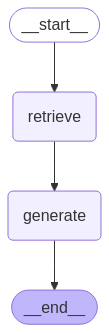

In [39]:
# --- 0. Imports ------------------------------------------------------------
from langgraph.graph import StateGraph, END
from typing import TypedDict, List

from langchain_community.vectorstores import Chroma                        # :contentReference[oaicite:4]{index=4}
from langchain_huggingface import HuggingFaceEmbeddings                    # :contentReference[oaicite:5]{index=5}
from langchain.retrievers import EnsembleRetriever                         # :contentReference[oaicite:6]{index=6}
from langchain.prompts import PromptTemplate
                                       # :contentReference[oaicite:7]{index=7}
from langchain_core.documents import Document

# --- 1. Shared state -------------------------------------------------------
class GraphState(TypedDict):
    question: str
    context_docs: List[Document]
    answer: str

# --- 2. Global resources ---------------------------------------------------
# a) Embeddings (same model for both stores)


# b) Chroma vector stores
# docs_vs  = Chroma(
#     collection_name="lg_docs",
#     persist_directory="contextual_chunked_lg_docs",
#     embedding_function=embedding_model,
# )
code_vs  = Chroma(
    collection_name="lg_code",
    persist_directory="contextual_chunked_lg_docs/github_lg",  # same folder OK
    embedding_function=embedding_model,
)

# c) Ensemble retriever
# docs_ret = docs_vs.as_retriever(search_kwargs={"k": 6})
code_ret = code_vs.as_retriever(search_kwargs={"k": 6})

# ensemble_ret = EnsembleRetriever(
#     retrievers=[docs_ret, code_ret],
#     weights=[0.4, 0.6]             # tune after offline eval
# )

# --- 3. Node functions -----------------------------------------------------
def retrieval_node(state: GraphState):
    # docs = ensemble_ret.get_relevant_documents(state["question"])
    docs = code_vs.max_marginal_relevance_search(state["question"], k=5, fetch_k=10)
    return {"context_docs": docs}

def llm_answer_node(state: GraphState):
    context = "\n\n".join(
        f"[{d.metadata.get('path')}] {d.page_content}" for d in state["context_docs"]
    )

    prompt = PromptTemplate(
        template=(
            # "You are an Langgraph expert. Answer the question using ONLY the context. But keep in mind the context are like legos, you should create and craft the solutions based on context and own python knowledge "
            # "Context will provide you the github repository code but you should respond with codes from the prespective of user. For e.g. context will have core classes of how pandas is written but you should provide codes as to how developer will use pandas `from pandas import pd` and other functionalities"
            # "Quote file paths in brackets when you cite.\n\n"
            # "<context>\n{context}\n</context>\n\n"
            # "Question: {question}\nAnswer:"
            """ 
                You are an expert Python developer and LangGraph specialist, with deep knowledge of large language model orchestration, graph-based workflows, and system integration.

                You are provided with context containing code snippets, architecture patterns, and documentation extracted from the official LangGraph repository and guides.  
                Your task is to **build developer-usable solutions** and **explain system behaviors clearly and professionally**, depending on the type of question.

                Follow these strict rules based on the nature of the question:

                ---

                ## 🛠️ For Developer-Focused Coding Questions:

                1. **Developer's Perspective:**
                    - Focus on writing practical, runnable code that a normal Python developer would use.
                    - Prefer using built-in constructs directly (`StateGraph`, `END`, node functions, `add_node`, `add_edge`, etc.).
                    - Do **NOT** redefine or reimplement core framework elements unless explicitly asked.

                2. **Solution Crafting Approach:**
                    - Treat the provided context as "building blocks" and connect them logically (like graph nodes).
                    - If minor logical gaps exist, fill them using standard Python best practices.
                    - Prioritize immediately runnable, graph-structured code examples.

                3. **Coding Style Expectations:**
                    - Include necessary imports and modularize code (separate graph definition, node functions, etc.).
                    - Show simple execution examples when appropriate (e.g., running a graph, initializing with input state).
                    - Minimize explanations — focus on delivering working graph flows.
                    - Assume reasonable defaults for common LangGraph patterns (like async support, error handling) if not fully detailed.

                4. **Contextual References:**
                    - If referring to specific files or modules, mention them clearly in brackets (e.g., `[src/langgraph/graph/state_graph.py]`).

                5. **Tone and Format:**
                    - Be concise, direct, and action-oriented.
                    - Only explain beyond the code when absolutely necessary to understand the graph structure.

                ---

                ## 🧠 For System Behavior / Senior Management / Architecture Questions:

                1. **Architecture and Integration Focus:**
                    - Explain system behaviors, memory handling, node orchestration, concurrency management, and extensibility clearly and professionally.
                    - Focus on the "what" and "why" behind LangGraph's graph-based design.
                    - Keep explanations business-relevant and avoid unnecessary technical deep-dives unless requested.

                2. **Explanation Crafting Approach:**
                    - Base answers on the provided context; intelligently fill minor gaps using industry-standard LLM workflow knowledge.
                    - Highlight modularity, parallelism, customization of edges, state passing, and ease of integrating LLMs or tools.

                3. **System Design Style Expectations:**
                    - Provide executive-friendly insights that enable decision-making.

                4. **Contextual References:**
                    - Mention source files explicitly in brackets when applicable (e.g., `[src/langgraph/graph/state_graph.py]`).

                5. **Tone and Format:**
                    - Be clear, confident, and precise.
                    - Summarize key advantages, trade-offs, and integration readiness.
                    - Always give an intuitive understanding of the topic first, then map this example with the technical jargons
                    - Give output in the markdown format making sure that user understands it easily.

                ---

                <context>  
                {context}  
                </context>

                Question: {question}  
                Answer:


                """
        ),
        input_variables=["context", "question"],
    )

    
    # chain = prompt | gemini_llm
    chain = prompt | llm


    result = chain.invoke({"context": context, "question": state["question"]})
    return {"answer": result}

# --- 4. Build the LangGraph -----------------------------------------------
graph = StateGraph(GraphState)
graph.add_node("retrieve", retrieval_node)
graph.add_node("generate", llm_answer_node)

graph.set_entry_point("retrieve")
graph.add_edge("retrieve", "generate")
graph.set_finish_point("generate")

rag_graph = graph.compile()

rag_graph


In [37]:
# --- 5. Run a test ---------------------------------------------------------
# question = "How to strore interactions using DatabaseSessionService (when i run adk web). Tell me the exact command i should run ?"
question = "How is memory stored in langgraph ? how can i use DB to store the same "

response = rag_graph.invoke({"question": question})

print("🧠 Answer:\n", response["answer"].content)

🧠 Answer:
 Based on the provided context, LangGraph handles memory and persistence primarily through two mechanisms: the **Checkpointer** and the **Store**.

1.  **Checkpointer:**
    *   Saves the *state* of a specific thread or run.
    *   This state is typically the return value of the previous invocation of the entrypoint function (or the value specified by `entrypoint.final.save`).
    *   It's used for resuming interrupted workflows and accessing the output of the immediately preceding step within the same thread via the `previous` parameter [langgraph/func/__init__.py].
    *   You configure it by passing a `checkpointer` instance (like `MemorySaver`) to the `@entrypoint` decorator [langgraph/func/__init__.py].

2.  **Store:**
    *   Provides a mechanism for "long-term memory" or "cross-thread memories" [langgraph/sdk-py/schema.py].
    *   It is a generalized key-value store implementing the `BaseStore` interface [langgraph/config.py].
    *   Data is stored as `Item` objects

In [35]:
# --- 5. Run a test ---------------------------------------------------------
# question = "How to strore interactions using DatabaseSessionService (when i run adk web). Tell me the exact command i should run ?"
question = """

Create a multi-agent system for me, should be a chatbot that has memory inbuilt and storing the memory in DB 



"""
response = rag_graph.invoke({"question": question})

print("🧠 Answer:\n", response["answer"].content)

🧠 Answer:
 Based on the provided context, the most relevant function for creating a chatbot with memory is `create_react_agent`. The context shows how this function can incorporate thread-level memory using a `checkpointer` and also mentions the use of a `store` for cross-thread memory.

However, the provided context *does not* contain code examples for:
1.  Building the structure of a *multi-agent* system (connecting multiple distinct agents). `create_react_agent` builds a single agent loop (LLM + Tools). While it mentions being usable *within* multi-agent systems, the code to *create* the multi-agent structure itself is not present.
2.  Using a *database* specifically for the `checkpointer` or `store`. The examples provided use `MemorySaver` for the checkpointer and `InMemoryStore` for the store.

Therefore, I can show you how to create a *single* agent chatbot with in-memory thread memory and demonstrate the pattern for using an in-memory store for cross-thread memory, as these are 

In [40]:
# --- 5. Run a test ---------------------------------------------------------
# question = "How to strore interactions using DatabaseSessionService (when i run adk web). Tell me the exact command i should run ?"
question = """
How does memory management works, explain right from question to storing the memory of the user queries etc. 
"""
response = rag_graph.invoke({"question": question})

print("🧠 Answer:\n", response["answer"].content)

🧠 Answer:
 ## Memory Management in LangGraph
### Overview
LangGraph's memory management is a crucial component that enables the storage and retrieval of user queries, intermediate results, and other relevant data. This explanation will walk through the process of memory management, from receiving a user query to storing the memory.

### Step 1: Receiving User Query
When a user submits a query, it is processed by the LangGraph application. The query is then passed through the graph-based workflow, where it is analyzed and executed.

### Step 2: Memory Store Configuration
The memory store is configured using the `StoreConfig` class, which defines the settings for the built-in long-term memory store. The configuration includes options for semantic search, TTL (time-to-live) behavior, and other settings.

```python
[libs/cli/langgraph_cli/config.py]
class StoreConfig(TypedDict, total=False):
    index: Optional[IndexConfig]
    ttl: Optional[TTLConfig]
```

### Step 3: Storing Data in Memo